In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests

df = pd.read_csv('data_clean.csv')

In [17]:
used_columns = [
    # demographic
    'ResponseId', 'Gender', 'Age', 'Commitment',
    # pre task attitude, information source, prior knowledge, openness
    'Attitude_1', 'Source', 'Knowledge_1', 'Pre tolerance',
    # post query attitude, perceptions diversity and familiarity
    'Post q1 attitude_1', 'Post q1 perception_1', 'Post q1 familiarity_1', 
    'Post q2 attitude_1', 'Post q2 perception_1', 'Post q2 familiarity_1',
    'Post q3 attitude_1', 'Post q3 perception_1', 'Post q3 familiarity_1',
    # post task explanation
    'Explain q1 click', 'Explain q1 click_10_TEXT', 'Explain q1 mark', 'Explain q1 mark_10_TEXT',
    'Explain q2 click', 'Explain q2 click_10_TEXT', 'Explain q2 mark', 'Explain q2 mark_10_TEXT',
    'Explain q3 click', 'Explain q3 click_10_TEXT', 'Explain q3 mark', 'Explain q3 mark_10_TEXT',
    # flipped (the first query is biased) or not (balanced)
    'QueryOrder',
    # task and topic conditions
    'topic', 'topic_class', 'condition',
    # condition of each query
    'random_q1', 'random_q2', 'random_q3',
    # interaction array
    'click_q1', 'dwelltime_q1', 'sequence_q1', 'bookmark_q1', 'more_q1',
    'usefulness_q1', 'credibility_q1', 
    'click_q2', 'dwelltime_q2', 'sequence_q2', 'bookmark_q2', 'more_q2', 
    'usefulness_q2', 'credibility_q2',
    'click_q3', 'dwelltime_q3', 'sequence_q3', 'bookmark_q3', 'more_q3', 
    'usefulness_q3', 'credibility_q3',
    # attidute direction and strength
    'Att_direct', 'Att_strength',
    # directional attitude changes
    'att_change_q1', 'att_change_q2', 'att_change_q3',
    # absolute attitude changes
    'att_step_q1', 'att_step_q2', 'att_step_q3', 'att_step_total',
    # direction of selected query's attitude
    'q1_direct_att', 'q2_direct_att', 'q3_direct_att',
    # aggregated interaction
    'click_q1_sum', 'click_q2_sum', 'click_q3_sum',
    'bookmark_q1_sum', 'bookmark_q2_sum', 'bookmark_q3_sum',
    'dwelltime_q1_sum', 'dwelltime_q2_sum', 'dwelltime_q3_sum',
    'usefulness_q1_sum', 'usefulness_q2_sum', 'usefulness_q3_sum',
    'credibility_q1_sum', 'credibility_q2_sum', 'credibility_q3_sum',
    'click_q1_rank', 'click_q1_depth',
    'click_q2_rank', 'click_q2_depth',
    'click_q3_rank', 'click_q3_depth',
    'bookmark_q1_avg', 'bookmark_q2_avg', 'bookmark_q3_avg',
    'dwelltime_q1_avg', 'dwelltime_q2_avg',  'dwelltime_q3_avg',
    'usefulness_q1_avg', 'usefulness_q2_avg', 'usefulness_q3_avg',
    'credibility_q1_avg', 'credibility_q2_avg', 'credibility_q3_avg',
    # proportion of interaction on attitude-confirming results
    'click_q1_prop', 'click_q1_prop_nor', 'dwelltime_q1_prop',
    'usefulness_q1_prop', 'credibility_q1_prop',
    'click_q2_prop', 'click_q2_prop_nor', 'dwelltime_q2_prop',
    'usefulness_q2_prop',  'credibility_q2_prop',
    'click_q3_prop', 'click_q3_prop_nor', 'dwelltime_q3_prop',
    'usefulness_q3_prop', 'credibility_q3_prop']

## Results of talbe 4 attitude changes

In [3]:
# calculate the undirectional attitude strength
df['Att_strength'] = (df['Attitude_1'] - 4) * df['Att_direct']

# calculate the directional attitude changes between queries
df['att_post_q1'] = (df['Post q1 attitude_1'] - df['Attitude_1']) * df['Att_direct']
df['att_post_q2'] = (df['Post q2 attitude_1'] - df['Post q1 attitude_1']) * df['Att_direct']
df['att_post_q3'] = (df['Post q3 attitude_1'] - df['Post q2 attitude_1']) * df['Att_direct']

# present the descriptive results of the attitude changes
# directional mean
print(df[['att_post_q1', 'att_post_q2', 'att_post_q3', 'att_change_q3']].describe())
# absolute mean
print(df[['att_step_q1', 'att_step_q2', 'att_step_q3', 'att_step_total']].describe())


       att_post_q1  att_post_q2  att_post_q3  att_change_q3
count  1321.000000  1321.000000  1321.000000    1321.000000
mean     -0.760787    -0.080242     0.026495      -0.814534
std       0.854759     0.766483     0.808137       0.976062
min      -5.000000    -4.000000    -5.000000      -6.000000
25%      -1.000000     0.000000     0.000000      -1.000000
50%      -1.000000     0.000000     0.000000      -1.000000
75%       0.000000     0.000000     0.000000       0.000000
max       2.000000     4.000000     5.000000       2.000000
       att_step_q1  att_step_q2  att_step_q3  att_step_total
count  1321.000000  1321.000000  1321.000000     1321.000000
mean      0.815291     0.378501     0.400454        1.594247
std       0.802898     0.671243     0.702355        1.562951
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000     0.000000        1.000000
50%       1.000000     0.000000     0.000000        1.000000
75%       1.000000     1.000000  

## Results of table 5 correlation matrix attitude changes and user characteristics

In [4]:
df_ac = df[['Att_strength','Knowledge_1','Pre tolerance','att_change_q3','att_step_total']]

from scipy.stats import pearsonr, spearmanr
rho = df_ac.corr('spearman')
pval = df_ac.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho=rho.round(2).astype(str) + p

print(rho)

               Att_strength Knowledge_1 Pre tolerance att_change_q3  \
Att_strength         1.0***     0.54***       0.37***      -0.28***   
Knowledge_1         0.54***      1.0***       0.39***         -0.02   
Pre tolerance       0.37***     0.39***        1.0***          0.04   
att_change_q3      -0.28***       -0.02          0.04        1.0***   
att_step_total       0.1***     -0.1***        -0.07*      -0.53***   

               att_step_total  
Att_strength           0.1***  
Knowledge_1           -0.1***  
Pre tolerance          -0.07*  
att_change_q3        -0.53***  
att_step_total         1.0***  


## Experiments for H1 and H2

In [5]:
behaviors_all = ['click_%s_sum', 'click_%s_rank', 'click_%s_depth', 'dwelltime_%s_avg', 'bookmark_%s_avg', 'more_%s','usefulness_%s_avg', 'credibility_%s_avg', 'Post %s perception_1', 'Post %s familiarity_1']

behaviors_prop = ['click_', 'dwelltime_', 'usefulness_', 'credibility_']

def bea_table(query):
    behaviors = behaviors_all.copy()

    data = df.loc[df['QueryOrder']=='flipped'].copy()
    data['more_%s'%(query)].fillna(0, inplace=True)

    data['post_q1_direct_att'] = data['q2_direct_att']
    data['post_q2_direct_att'] = data['q3_direct_att']

    condition1 = ['balanced','reinforce_r','reinforce_d','rank','diverse','obfuscated']
    condition2 = ['balanced', 'rank', 'diverse']

    if query=='q1':
        conditions = condition1
        condition_at = 'random_q1'
    elif query=='q2':
        conditions = ['balanced-'+j for j in condition1]
        condition_at = 'condition'
    elif query=='q3':
        conditions = [i+'-'+j for i in condition2 for j in condition1]
        condition_at = 'condition'

    print(*[len(data.loc[data[condition_at]==con]) for con in conditions])
    p_list = {}
    for b in behaviors:
        print(b, *[data.loc[data[condition_at]==con][b%(query)].mean().round(3) for con in conditions], end=' ')
        p_list[b%(query)] = p_val = stats.kruskal(*[data.loc[data[condition_at]==con][b%(query)] for con in conditions], nan_policy='omit')
        print(p_val[1].round(4))
        if p_val[1] < 0.05:
            conover_results = sp.posthoc_conover(data, val_col=b%(query), group_col=condition_at, p_adjust = 'holm')
            print(conover_results.round(4).to_string())

    for b in behaviors_prop:
        if b != 'click_':
            data = data.loc[data['click_%s_prop'%(query)]!=0].copy()
        else:
            print(b, *[data.loc[data[condition_at]==con][b+query+'_prop_nor'].mean().round(3) for con in conditions], end=' ')
            p_list[b+query] = p_val = stats.kruskal(*[data.loc[data[condition_at]==con][b+query+'_prop_nor'] for con in conditions])
            print(p_val[1].round(4))
        print(b, *[data.loc[data[condition_at]==con][b+query+'_prop'].mean().round(3) for con in conditions], end=' ')
        p_list[b+query] = p_val = stats.kruskal(*[data.loc[data[condition_at]==con][b+query+'_prop'] for con in conditions], nan_policy='omit')
        print(p_val[1].round(4))
        if p_val[1] < 0.05:
            conover_results = sp.posthoc_conover(data, val_col=b+query+'_prop', group_col=condition_at, p_adjust = 'holm')
            print(conover_results.round(4).to_string())

    df_p = pd.DataFrame.from_dict(p_list, orient="index", columns=["H_score","p_val"])
    df_p['corrected_p'] = multipletests(df_p['p_val'], method='fdr_bh')[1]
    df_p.loc[df_p['corrected_p']<=0.05,'sign'] = '*'
    df_p.loc[df_p['corrected_p']<=0.01,'sign'] = '**'

    return df_p 

### Results of table 6 search features across different SERP in the first query

In [7]:
fea_q1=bea_table('q1')

138 133 131 131 132 128
click_%s_sum 3.971 3.805 3.618 5.298 3.553 3.539 0.0
             balanced  diverse  obfuscated  rank  reinforce_d  reinforce_r
balanced       1.0000      1.0         1.0   0.0       0.9466          1.0
diverse        1.0000      1.0         1.0   0.0       1.0000          1.0
obfuscated     1.0000      1.0         1.0   0.0       1.0000          1.0
rank           0.0000      0.0         0.0   1.0       0.0000          0.0
reinforce_d    0.9466      1.0         1.0   0.0       1.0000          1.0
reinforce_r    1.0000      1.0         1.0   0.0       1.0000          1.0
click_%s_rank 4.529 4.462 4.349 5.025 3.961 5.713 0.0
             balanced  diverse  obfuscated    rank  reinforce_d  reinforce_r
balanced        1.000   0.2150       0.000  0.2150       1.0000       1.0000
diverse         0.215   1.0000       0.000  0.0003       1.0000       0.7311
obfuscated      0.000   0.0000       1.000  0.0350       0.0000       0.0000
rank            0.215   0.0003      

In [8]:
print(fea_q1)

                          H_score         p_val   corrected_p sign
click_q1_sum           200.311796  2.436198e-41  1.705339e-40   **
click_q1_rank           62.032821  4.616620e-12  2.154423e-11   **
click_q1_depth          50.266848  1.222043e-09  4.277150e-09   **
dwelltime_q1_avg         1.785187  8.779977e-01  9.455360e-01  NaN
bookmark_q1_avg          4.909772  4.269908e-01  6.642079e-01  NaN
more_q1                 13.158247  2.194010e-02  5.119357e-02  NaN
usefulness_q1_avg        3.731380  5.887011e-01  8.241816e-01  NaN
credibility_q1_avg       0.698700  9.830399e-01  9.830399e-01  NaN
Post q1 perception_1     2.518986  7.736331e-01  9.025720e-01  NaN
Post q1 familiarity_1    8.586651  1.267312e-01  2.534625e-01  NaN
click_q1               438.599764  1.413058e-92  1.978281e-91   **
dwelltime_q1            34.251687  2.121480e-06  5.940143e-06   **
usefulness_q1            2.857556  7.219352e-01  9.025720e-01  NaN
credibility_q1           6.757388  2.393180e-01  4.188064e-01 

### Results of features in the second query

In [ ]:
fea_q2=bea_table('q2')

### Results of features in the third query

In [9]:
fea_q3=bea_table('q3')

58 38 43 42 46 40 41 45 45 52 43 45 39 50 43 37 43 43
click_%s_sum 3.621 3.447 3.279 3.429 3.5 3.5 3.146 3.689 3.711 3.981 3.302 3.778 3.795 3.48 3.395 3.514 3.186 3.279 0.4518
click_%s_rank 4.967 4.087 4.49 4.81 4.555 4.975 4.93 4.891 4.346 5.017 4.165 4.359 3.829 4.66 4.57 4.467 4.699 4.173 0.5495
click_%s_depth 7.207 6.289 6.605 7.119 7.196 7.275 7.39 7.333 6.444 7.519 6.279 6.622 6.231 6.72 7.116 6.649 7.047 6.488 0.6097
dwelltime_%s_avg 4.747 5.646 7.511 4.475 7.944 4.554 6.946 6.402 6.204 8.954 4.876 4.287 7.398 6.792 7.992 5.474 11.231 6.687 0.5182
bookmark_%s_avg 0.494 0.342 0.587 0.465 0.489 0.471 0.266 0.517 0.344 0.399 0.45 0.454 0.385 0.372 0.445 0.466 0.503 0.375 0.3542
more_%s 0.052 0.0 0.023 0.071 0.065 0.15 0.049 0.044 0.044 0.077 0.047 0.067 0.026 0.06 0.07 0.054 0.07 0.047 0.8079
usefulness_%s_avg 2.89 2.971 2.88 3.046 2.939 3.007 2.941 3.127 3.093 2.891 2.72 2.975 2.902 2.877 2.752 3.051 3.087 2.769 0.4026
credibility_%s_avg 2.892 2.947 2.985 3.047 2.99 3.0 3.01 3.07

In [10]:
print(fea_q3)

                         H_score     p_val  corrected_p sign
click_q3_sum           17.037276  0.451843     0.681982  NaN
click_q3_rank          15.639887  0.549492     0.681982  NaN
click_q3_depth         14.802129  0.609732     0.681982  NaN
dwelltime_q3_avg       16.079252  0.518224     0.681982  NaN
bookmark_q3_avg        18.561917  0.354249     0.681982  NaN
more_q3                11.870809  0.807896     0.807896  NaN
usefulness_q3_avg      17.783733  0.402606     0.681982  NaN
credibility_q3_avg     16.726953  0.473009     0.681982  NaN
Post q3 perception_1   18.817446  0.339111     0.681982  NaN
Post q3 familiarity_1  40.417411  0.001130     0.015816    *
click_q3               14.474594  0.633269     0.681982  NaN
dwelltime_q3           21.331006  0.211833     0.681982  NaN
usefulness_q3          23.627018  0.129929     0.681982  NaN
credibility_q3         17.470161  0.422978     0.681982  NaN


### Present figure 2 distribution of the familiarity in the third query

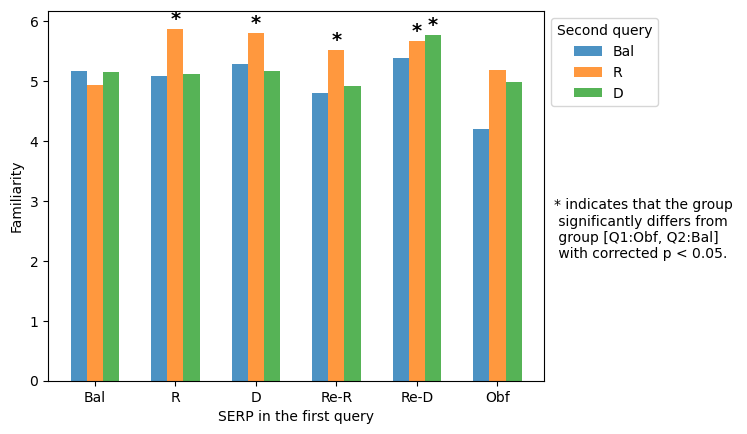

In [12]:
data = [[5.16,5.08,5.28,4.79,5.39,4.2], [4.93,5.87,5.8,5.52, 5.67,5.18],[ 5.15,5.12,5.16,4.92,5.77,4.98]]

data = np.array(data)

# calculate the number of sublists and data points
num_sublists = len(data)
num_data_points = len(data[0])

# create the bar plot
fig, ax = plt.subplots()
bar_width = 0.2
opacity = 0.8

labels = ['Bal','R','D']

# plot each set of bars
for i in range(num_sublists):
    x_pos = np.arange(num_data_points) + i * bar_width
    ax.bar(x_pos, data[i], bar_width,
           alpha=opacity,
           label=labels[i])
    for idx, j in enumerate(x_pos):
        if data[i][idx]>5.5:
            ax.text(j, data[i][idx], '*',
                    ha='center', va='bottom', fontweight='bold', size=14)

t = '* indicates that the group \n significantly differs from \n group [Q1:Obf, Q2:Bal] \n with corrected p < 0.05.'

ax.text(5.9, 2, t, ha='left', va='bottom', size=10)
# set axis labels and title
ax.set_xlabel('SERP in the first query')
ax.set_ylabel('Familiarity')
# ax.set_title('Bar chart of given list')

# set x-axis tick labels
ax.set_xticks(np.arange(num_data_points) + (num_sublists-1) * bar_width / 2)
ax.set_xticklabels(['Bal','R','D', 'Re-R', 'Re-D', 'Obf'])

# add legend and show plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1),title="Second query")
plt.show()

## Experiments for H3

In [14]:
def print_att(pre_condition=1):
    zero = (df['condition'] == 'balanced-balanced') & pre_condition
    bias1_1 = (df['random_q2']=='balanced') & (df['random_q1'].str.contains('reinforce')) & (df['QueryOrder']=='flipped') & pre_condition
    bias1_2 = (df['random_q2']!='balanced') & (df['random_q1']=='balanced') & (df['random_q3']=='balanced') & pre_condition
    bias1_3 = (df['random_q2']=='balanced') & (df['random_q3'].str.contains('reinforce')) & (df['QueryOrder'].isna()) & pre_condition

    bias2_1 = (df['random_q2']!='balanced') & (df['random_q1'].str.contains('reinforce')) & (df['QueryOrder']=='flipped') & pre_condition
    bias2_2 = (df['random_q2']!='balanced') & (df['random_q3'].str.contains('reinforce')) & (df['QueryOrder'].isna()) & pre_condition

    miti1 = (df['random_q2']=='balanced') & (~df['random_q1'].str.contains('reinforce|balanced')) & (df['QueryOrder']=='flipped') & pre_condition
    miti2 = (df['random_q2']=='balanced') & (~df['random_q3'].str.contains('reinforce|balanced')) & (df['QueryOrder'].isna()) & pre_condition

    miti_b1 = (df['random_q2']!='balanced') & (~df['random_q1'].str.contains('reinforce|balanced')) & (df['QueryOrder']=='flipped') & pre_condition
    miti_b2 = (df['random_q2']!='balanced') & (~df['random_q3'].str.contains('reinforce|balanced')) & (df['QueryOrder'].isna()) & pre_condition

    p_list = {}
    i = 1
    for con in  [zero, bias1_1, bias1_2, bias1_3, bias2_1, bias2_2, miti1, miti2, miti_b1, miti_b2]:
        print(len(df.loc[con]),
              # 	   df.loc[con]['att_overall'].mean().round(2),
              df.loc[con]['att_post_q1'].mean().round(2),
              df.loc[con]['att_post_q2'].mean().round(2),
              df.loc[con]['att_post_q3'].mean().round(2),
              df.loc[con]['att_step_total'].mean().round(2),
              df.loc[con]['att_change_q3'].mean().round(2),
              round(len(df.loc[con & (df['att_step_total']==0)])/len(df.loc[con]),2))

        if type(pre_condition)==int:
            for att in ['att_step_total','att_change_q3']:
                p_list[att+'_strength_'+str(i)] = stats.kruskal(*[df.loc[con & (df['Att_strength']==j)][att] for j in [1,2,3]])[1]
                p_list[att+'_knowledge_'+str(i)] = stats.kruskal(df.loc[con & (df['Knowledge_1']>=6)][att],
                                                                 df.loc[con & (df['Knowledge_1']<6)][att])[1]
                p_list[att+'_tolerance_'+str(i)] = stats.kruskal(df.loc[con & (df['Pre tolerance']>=6)][att],
                                                                 df.loc[con & (df['Pre tolerance']<6)][att])[1]
        i += 1
    conditions = [[bias1_1, bias1_2, bias1_3],
                  [bias2_1, bias2_2],
                  [miti1, miti2],
                  [miti_b1, miti_b2]]
    i=1
    for con in conditions:
        p_list['att_step_total_pos_'+str(i)] = stats.kruskal(*[df.loc[c]['att_step_total'] for c in con])
        p_list['att_change_q3_pos_'+str(i)] = stats.kruskal(*[df.loc[c]['att_change_q3'] for c in con])
        i+=1
        
    conditions = [bias1_1 | bias1_2 | bias1_3,
                  bias2_1 | bias2_2,
                  miti1 | miti2,
                  miti_b1 | miti_b2, zero]

    p_list['att_step_total_level'] = stats.kruskal(*[df.loc[con]['att_step_total'] for con in conditions])
    p_list['att_change_q3_level'] = stats.kruskal(*[df.loc[con]['att_change_q3'] for con in conditions])

    df_p = pd.DataFrame.from_dict(p_list, orient="index", columns=["H_score","p_val"])
    df_p['corrected_p'] = multipletests(df_p['p_val'], method='fdr_bh')[1]
    df_p.loc[df_p['corrected_p']<=0.05,'sign'] = '*'
    df_p.loc[df_p['corrected_p']<=0.01,'sign'] = '**'

    return df_p

### Results of table 7 attitude changes in different bias position conditions when openness < 6

In [15]:
low_open = print_att((df['Pre tolerance']<6))

13 -1.0 0.46 -0.31 2.23 -0.85 0.15
30 -0.83 -0.07 -0.37 2.27 -1.27 0.1
38 -0.71 -0.03 0.24 1.55 -0.5 0.24
19 -0.74 -0.11 -0.05 1.42 -0.89 0.21
39 -0.74 0.28 -0.13 1.72 -0.59 0.44
46 -0.96 -0.09 -0.02 1.89 -1.07 0.15
36 -0.86 -0.08 0.11 1.67 -0.83 0.19
24 -0.88 -0.17 -0.04 1.83 -1.08 0.17
67 -0.93 -0.07 0.15 2.04 -0.85 0.18
37 -0.97 -0.24 -0.3 2.16 -1.51 0.16


In [16]:
print(low_open)

                       H_score     p_val  corrected_p sign
att_step_total_pos_1  3.104834  0.211736     0.423471  NaN
att_change_q3_pos_1   9.918092  0.007020     0.035098    *
att_step_total_pos_2  3.031046  0.081685     0.204213  NaN
att_change_q3_pos_2   7.714362  0.005478     0.035098    *
att_step_total_pos_3  0.131791  0.716583     0.895728  NaN
att_change_q3_pos_3   0.004380  0.947235     0.947235  NaN
att_step_total_pos_4  0.017527  0.894676     0.947235  NaN
att_change_q3_pos_4   3.592648  0.058036     0.193452  NaN
att_step_total_level  3.213681  0.522724     0.848381  NaN
att_change_q3_level   2.788227  0.593867     0.848381  NaN


### Results of overall conditions and other sub conditions

In [ ]:
overall = print_att()
high_kown = print_att((df['Knowledge_1']>=6))
low_kown = print_att((df['Knowledge_1']<6))
high_open = print_att((df['Pre tolerance']>=6))
low_strength = print_att((df['Att_strength']==1))
mod_strength = print_att((df['Att_strength']==2))
high_strength = print_att((df['Att_strength']==3))